# Задание

### Задания для итоговой аттестации

<div class="alert alert-info">
Вы выбрали Dataset из списка, проведите полный цикл работы над вашим проектом, что проходили ранее. Pipeline выполнения задачи:

1. Загрузка и предобработка данных

2. Описательный анализ данных, просмотр данных и вывод статистики

3. Постройте необходимые графики для анализа

4. Проверьте гипотезы (если потребуется)

5. Сделайте промежуточный отчет-вывод по исследованию

6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

Рекомендации:

> Соблюдайте PEP8

> Комментируйте код в местах, где конструкция большая

> Оставляйте промежуточные выводы по вашему исследованию и построению модели (так кураторам будет проще понять ваши заключения)

> Экспериментируйте! Вы не ограничены в моделях и подходах. Можете использовать любые DS инструменты (и те, которые мы не разбирали с вами на курсе)

<div style='border:solid blue 2px; padding: 20px'>
    
Набор данных содержит транзакции, совершенные европейскими держателями карт с помощью кредитных карт в сентябре 2013 года.
В этом наборе данных представлены транзакции, которые произошли за два дня, где мы имеем 492 мошеннических действия из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничество) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем с конфиденциальностью мы не можем предоставить исходные функции и дополнительную справочную информацию о данных. Характеристики V1, V2, ... V28 являются основными компонентами, полученными с помощью PCA, единственными характеристиками, которые не были преобразованы с помощью PCA, являются "Время" и "Количество". Функция "Время" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция "Сумма" - это сумма транзакции, эту функцию можно использовать, например, для обучения, зависящего от затрат. Функция 'Class' является переменной ответа, и она принимает значение 1 в случае мошенничества и 0 в противном случае.

Учитывая коэффициент дисбаланса в классе, мы рекомендуем измерять точность, используя площадь под кривой возврата точности (AUPRC). Точность матрицы путаницы не имеет значения для несбалансированной классификации.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split, KFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
import collections

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info">

> 1. Загрузка и предобработка данных

> 2. Описательный анализ данных, просмотр данных и вывод статистики

> 3. Постройте необходимые графики для анализа

> 4. Проверьте гипотезы (если потребуется)

> 5. Сделайте промежуточный отчет-вывод по исследованию

In [2]:
df = pd.read_csv("./creditcard.csv")
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
15772,27209.0,-0.862364,0.771337,1.511572,-0.308411,0.775501,1.324414,0.276710,0.606522,-0.675709,...,-0.028383,0.094259,0.215039,-0.822632,-0.539626,0.159492,0.214096,0.085882,4.49,0
173920,121696.0,-3.626962,-5.790181,0.642301,2.275985,5.752470,-2.628261,-4.181447,0.885147,0.819484,...,0.812981,0.709203,1.554518,-0.174404,-2.037243,-0.938550,0.265395,0.512261,45.00,0
70684,53978.0,-0.189524,0.532069,0.959703,-0.563966,0.871565,-0.409734,0.661280,-0.085945,-0.260301,...,-0.252387,-0.750594,-0.065005,-0.616217,-0.330592,-0.088391,-0.188292,-0.211228,2.69,0
84353,60267.0,0.988141,-1.325375,0.976825,-0.351261,-1.781657,-0.436204,-0.861153,-0.052293,-0.178715,...,0.293338,0.477974,-0.186271,0.426083,0.275058,-0.208604,0.016235,0.061890,200.00,0
123147,76828.0,-0.151695,1.391027,-0.117154,0.982419,0.004758,-1.206156,0.614243,0.188524,-0.617635,...,0.168482,0.557174,0.067950,0.381697,-0.704821,-0.410989,0.312114,0.167122,0.89,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<div class="alert alert-success">
Все данные у нас количественные. Никаких пропусков не обнаружено

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

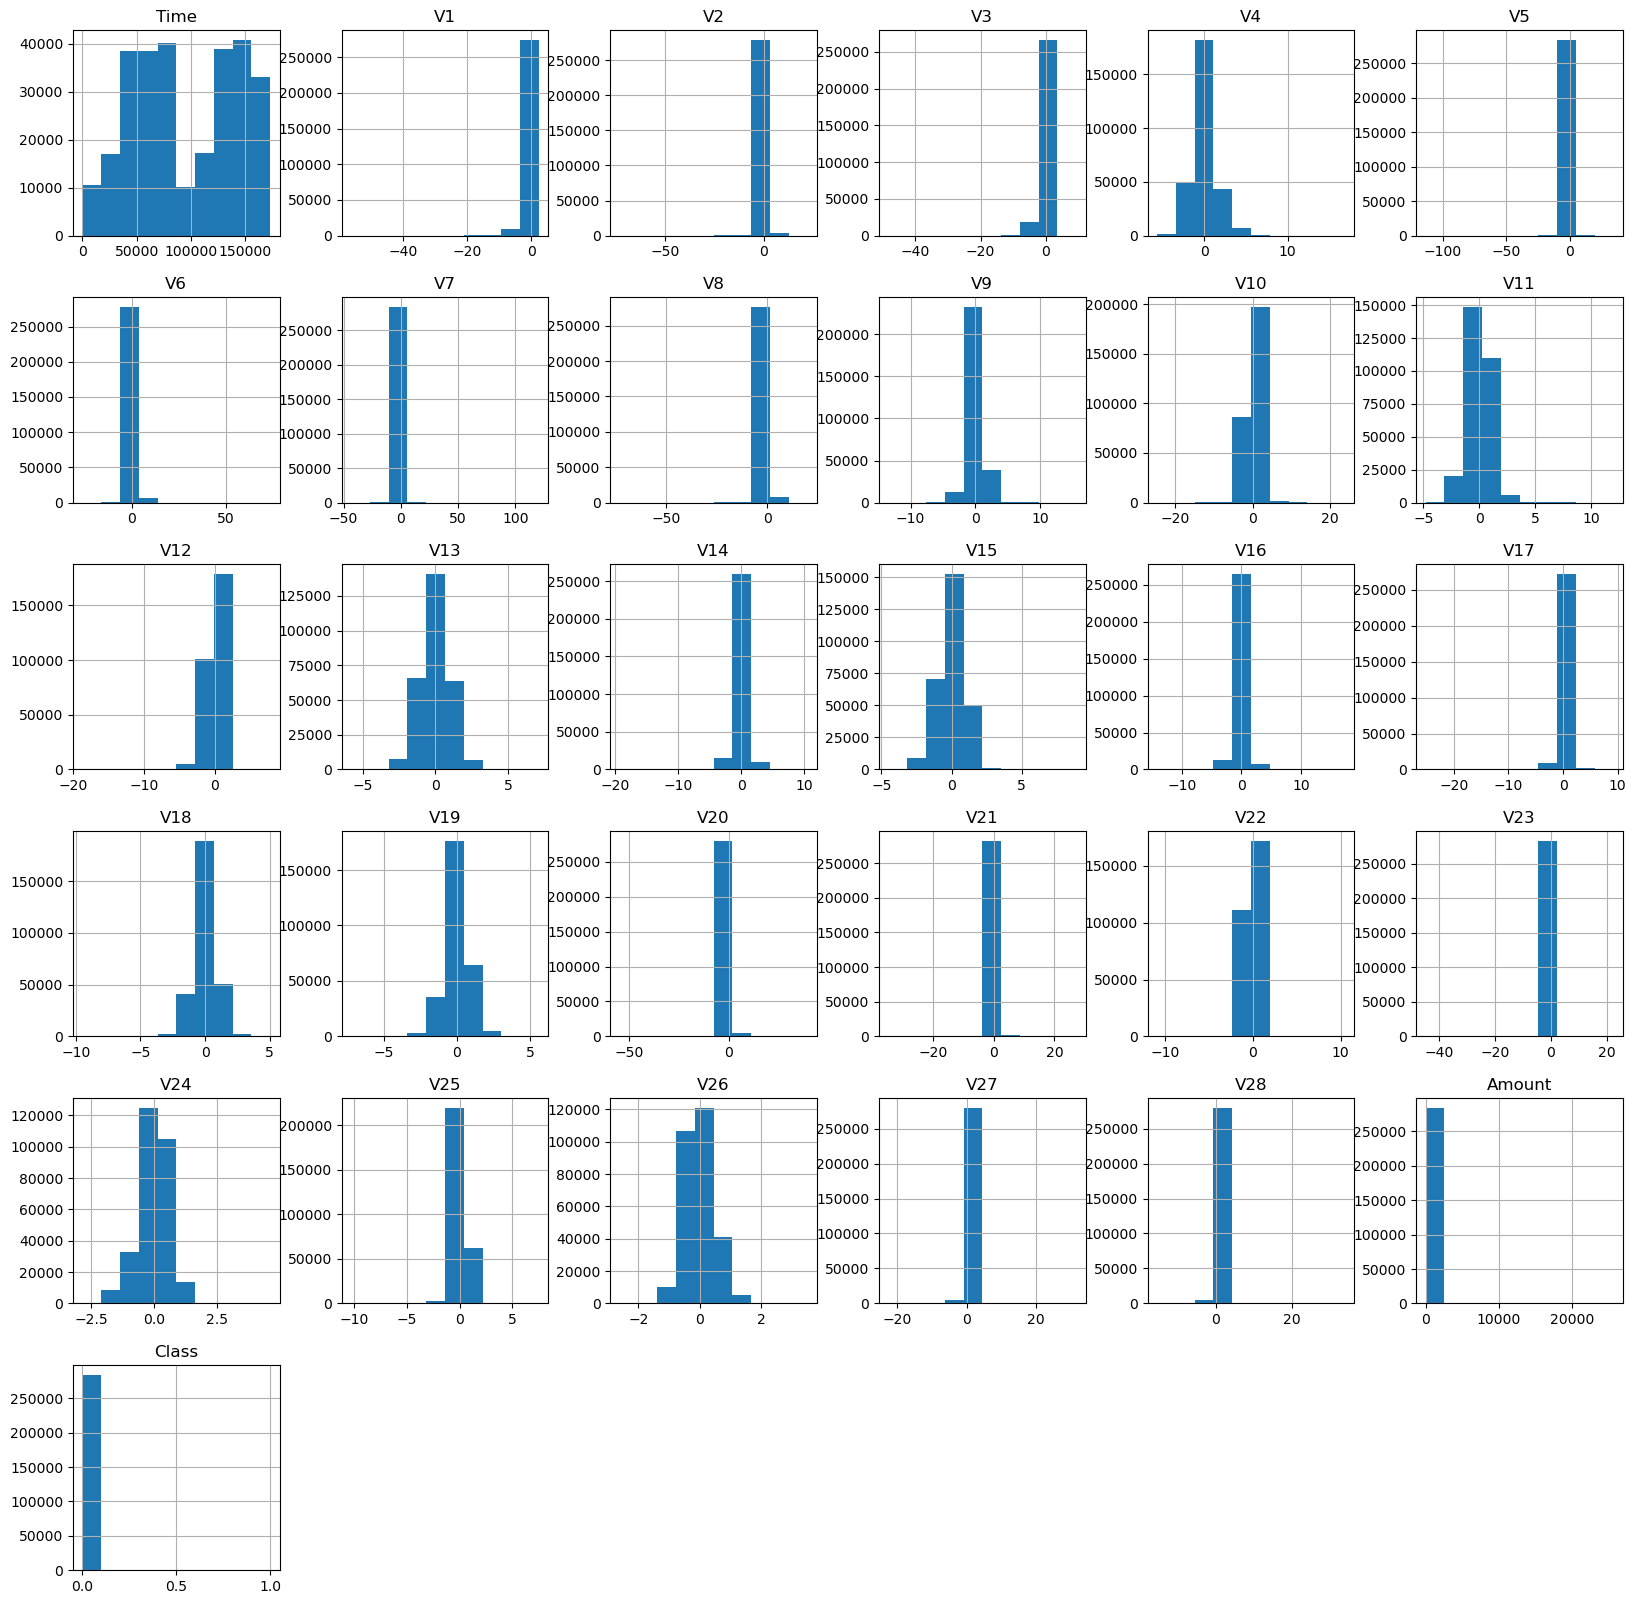

In [4]:
df.hist(figsize=(20, 20))

<div class="alert alert-warning">
Намеки на нормальное распределение отсутсвуют

**Проверка целевых классов**

Text(0, 0.5, 'Частота')

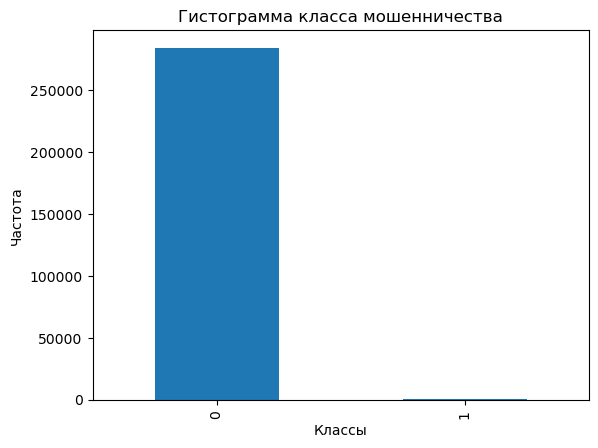

In [5]:
count_classes = pd.value_counts(df['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title("Гистограмма класса мошенничества")
plt.xlabel("Классы")
plt.ylabel("Частота")

<div class="alert alert-danger">
    
Распределения: Просматривая распределения, мы можем получить представление о том, насколько искажены эти функции, мы также можем увидеть дальнейшие распределения других функций. Существуют методы, которые могут помочь уменьшить перекосы в распределениях, которые будут реализованы в этой записной книжке в будущем.

(0.0, 172792.0)

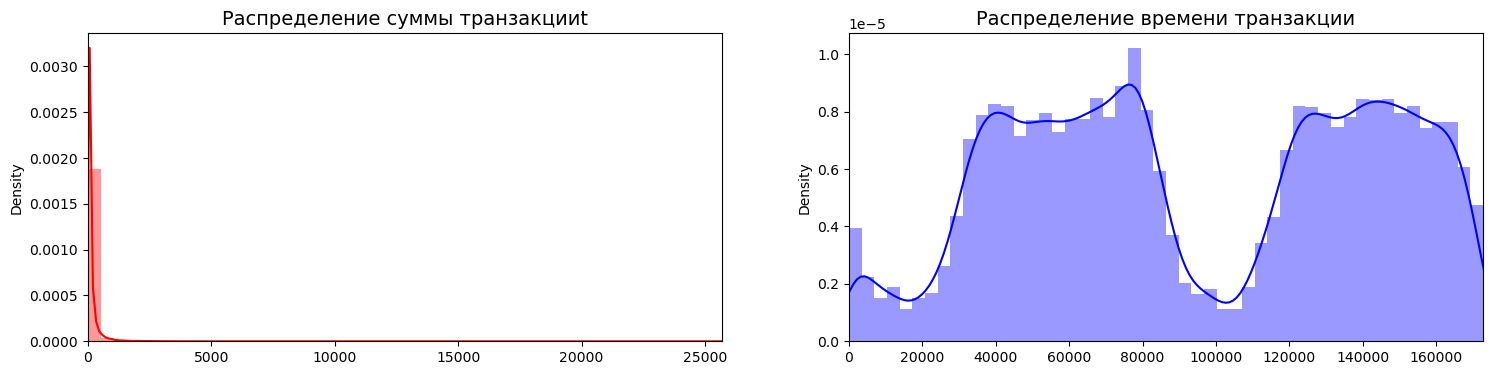

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Распределение суммы транзакцииt', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Распределение времени транзакции', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

### Вывод:
* Масштабируемое количество и масштабируемое время - это столбцы с масштабируемыми значениями.
* В нашем наборе данных имеется 492 случая мошенничества, поэтому мы можем случайным образом получить 492 случая, не связанных с мошенничеством, для создания нашего нового вложенного фрейма данных.
Мы объединяем 492 случая мошенничества и не-мошенничества, создавая новую подвыборку.

In [7]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Количество и время масштабируются!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Разделение данных (исходный фрейм данных)
Прежде чем приступить к методу случайной недостаточной дискретизации, мы должны отделить исходный фрейм данных. Почему? в целях тестирования помните, что, хотя мы разделяем данные при реализации методов случайной недостаточной или избыточной дискретизации, мы хотим протестировать наши модели на исходном тестовом наборе, а не на тестовом наборе, созданном с помощью любого из этих методов. Основная цель состоит в том, чтобы подогнать модель либо к кадрам данных, которые были подвергнуты недостаточной выборке, либо к избыточной выборке (для того, чтобы наши модели могли обнаруживать закономерности), и протестировать ее на исходном тестовом наборе.

In [8]:
print('Никакого мошенничества', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% из набора данных')
print('Мошенничества', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% из набора данных')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Превратиться в массив
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Проверьте, одинаково ли распределены как поезд, так и тестовая маркировка
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Распределение меток: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

Никакого мошенничества 99.83 % из набора данных
Мошенничества 0.17 % из набора данных
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Распределение меток: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [9]:
# Поскольку наши классы сильно искажены, мы должны сделать их эквивалентными, чтобы иметь нормальное распределение классов.

# Давайте перетасуем данные перед созданием подвыборок

df = df.sample(frac=1)

# количество классов мошенничества - 492 строки.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перетасовать строки фрейма данных
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
82815,0.695871,-0.295222,-0.235078,0.309578,0.971170,0.655970,0.033546,-0.313354,0.576937,-0.069565,...,0.341723,0.090150,0.304189,0.053966,0.179649,-0.222780,1.314432,-0.015725,0.040341,0
45203,-0.293440,-0.498655,-2.524012,2.098152,-4.946075,6.456588,3.173921,-3.058806,-0.184710,-0.390420,...,-0.162797,0.027935,0.220366,0.976348,-0.290539,1.161002,0.663954,0.456023,-0.405682,1
97855,-0.181933,-0.214735,-1.351155,1.636269,0.433361,-0.064121,-0.455136,-0.328741,-0.233063,1.109601,...,-0.041226,-0.139055,-0.559456,0.118521,-0.054054,-0.186839,0.095784,0.118628,0.007460,0
151196,7.678055,0.120537,0.842025,-0.365518,-2.464063,4.820886,0.775505,-0.614785,1.368024,-0.526262,...,0.944915,-0.110622,-1.257800,-0.324418,-0.420020,-0.219501,-0.268873,-0.144582,0.104464,1
99506,6.535457,-0.206088,-1.824295,0.403327,-1.994122,2.756558,-3.139064,0.408185,-1.209045,1.095634,...,1.503688,0.838760,0.341727,0.947506,-0.145493,0.049326,0.831065,0.332421,0.252713,1


Распределение классов в наборе данных подвыборки
0    0.5
1    0.5
Name: Class, dtype: float64


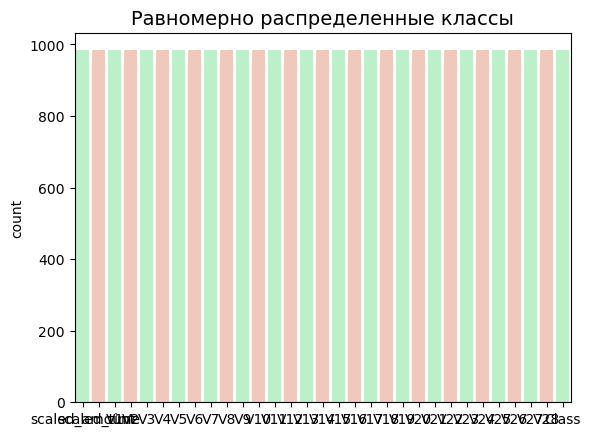

In [10]:
print('Распределение классов в наборе данных подвыборки')
print(new_df['Class'].value_counts()/len(new_df))


colors = ['#B3F9C5', '#f9c5b3']
sns.countplot(data=new_df, palette=colors)
plt.title('Равномерно распределенные классы', fontsize=14)
plt.show()

**Графики сломались**

<div class="alert alert-info">
    
> 6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

> 7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

> 8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

> 9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

> 10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

In [11]:
# New_df получен из случайных данных с недостаточной выборкой (меньше экземпляров)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# Реализация T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# Внедрение PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# Усеченный SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 9.4 s
PCA took 0.01 s
Truncated SVD took 0.019 s


<div class="alert alert-info">
    <b>Разделение данных на обучающий и тестовый наборы. При расчете точности будет использоваться перекрестная проверка. </b>


</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Объявления: ", classifier.__class__.__name__, "Имеет оценку за обучение в размере", round(training_score.mean(), 2) * 100, "% оценка точности")

Объявления:  LogisticRegression Имеет оценку за обучение в размере 93.0 % оценка точности
Объявления:  KNeighborsClassifier Имеет оценку за обучение в размере 93.0 % оценка точности
Объявления:  SVC Имеет оценку за обучение в размере 93.0 % оценка точности
Объявления:  DecisionTreeClassifier Имеет оценку за обучение в размере 92.0 % оценка точности


In [13]:
# Логистическая регрессия
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# Мы автоматически получаем логистическую регрессию с наилучшими параметрами.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# Приближается к наилучшей оценке
knears_neighbors = grid_knears.best_estimator_

# Классификатор опорных векторов
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# Наилучший оценщик SVC
svc = grid_svc.best_estimator_

# Классификатор дерева решений
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# наилучший оценщик дерева
tree_clf = grid_tree.best_estimator_

In [14]:
# Создайте фрейм данных со всеми оценками и названиями классификаторов.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [15]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9853079956046797
KNears Neighbors:  0.9312972658522396
Support Vector Classifier:  0.9857863098700795
Decision Tree Classifier:  0.9198888242518259


<div class="alert alert-success">

# Вывод:
    
1. В приведенных выше оценках Support Vector Classifier, по-видимому, является моделью с наилучшей.
    
2. ### «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?
    
> Машинное обучение нужно, так как задача требует анализа данныхи построения модели, которая может автоматически улучшаться на основе опыта. Однако, в некоторых случаях, можно обойтись dummy-предсказанием, если точность не является критическим фактором.